In [32]:
!pip uninstall numpy

In [ ]:
!pip install numpy==1.23.1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

In [2]:
# Carregamento dos dados
dataset = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

In [4]:
# verificar nan em dataset
display(dataset.isna().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
# Converter TotalCharges para float
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')

In [6]:
# verificar nan em dataset
display(dataset.isna().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [7]:
# Remover a coluna 'customerID'
dataset.drop('customerID', axis=1, inplace=True)

# Selecionar colunas categóricas, mantendo as colunas do tipo int e float no DataFrame
categorical_cols = dataset.select_dtypes(include=['object']).columns.tolist()

# Criar dummies para as colunas categóricas
dataset_dummies = pd.get_dummies(dataset, columns=categorical_cols, drop_first=False)

# Separar as features e o target
scaler = StandardScaler()
features_scaled = scaler.fit_transform(dataset_dummies.drop('TotalCharges', axis=1))  # remove 'TotalCharges' from the features

# Após a normalização, a coluna 'TotalCharges' é adicionada de volta ao array de features
features_scaled = np.column_stack((features_scaled, dataset_dummies['TotalCharges']))

imputer = KNNImputer(n_neighbors=10) # Usa o KNN para preencher os valores faltantes
features_imputed = imputer.fit_transform(features_scaled)

# Adicionar 'TotalCharges' como última coluna
dataset['TotalCharges'] = features_imputed[:, -1]

In [8]:
# Selecionar colunas categóricas, mantendo as colunas do tipo int e float no DataFrame
categorical_cols = dataset.select_dtypes(include=['object']).columns.tolist()

# Criar dummies para as colunas categóricas
dataset_dummies = pd.get_dummies(dataset, columns=categorical_cols, drop_first=False)

# Dividindo os dados em características e target
X = dataset_dummies.drop(['Churn_Yes', 'Churn_No'], axis=1)  # Características
y = dataset_dummies['Churn_Yes']  # Churn_Yes ja tem 0 e 1

In [9]:
# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# XGBoost

In [10]:
# Configuração do modelo XGBoost
xg_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.5,
    colsample_bytree=0.5,
    objective='binary:logistic',
    random_state=42
)

In [11]:
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [12]:
predictions = xg_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.8113475177304964
              precision    recall  f1-score   support

       False       0.84      0.91      0.88       511
        True       0.70      0.54      0.61       194

    accuracy                           0.81       705
   macro avg       0.77      0.73      0.74       705
weighted avg       0.80      0.81      0.80       705



# Rede neural

In [13]:
# Define the model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)), 
    Dropout(0.3), 
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3), 
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3), 
    Dense(1, activation='sigmoid') 
])

# Compile the model
nn_model.compile(optimizer='adam',
              loss= BinaryCrossentropy(from_logits=False), 
              metrics=['accuracy'])

# Print the model summary
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5888      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [14]:
# Convert data types
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

In [15]:
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
179/179 [==============================] - 2s 5ms/step - loss: 25.7494 - accuracy: 0.6413 - val_loss: 6.0420 - val_accuracy: 0.7823
Epoch 2/100
179/179 [==============================] - 1s 3ms/step - loss: 6.7227 - accuracy: 0.6534 - val_loss: 1.7292 - val_accuracy: 0.7808
Epoch 3/100
179/179 [==============================] - 1s 3ms/step - loss: 3.1121 - accuracy: 0.6630 - val_loss: 1.4061 - val_accuracy: 0.7618
Epoch 4/100
179/179 [==============================] - 1s 4ms/step - loss: 1.6795 - accuracy: 0.7049 - val_loss: 1.3620 - val_accuracy: 0.7618
Epoch 5/100
179/179 [==============================] - 1s 3ms/step - loss: 1.4902 - accuracy: 0.7309 - val_loss: 1.3467 - val_accuracy: 0.7618
Epoch 6/100
179/179 [==============================] - 1s 3ms/step - loss: 1.3839 - accuracy: 0.7397 - val_loss: 1.3151 - val_accuracy: 0.7618
Epoch 7/100
179/179 [==============================] - 1s 3ms/step - loss: 1.3596 - accuracy: 0.7390 - val_loss: 1.2891 - val_accuracy: 0.763

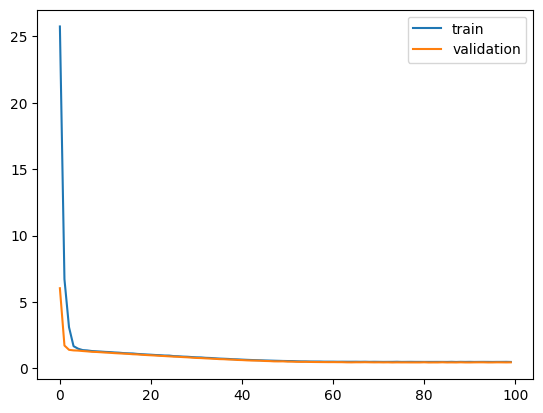

In [16]:
# plotar a curva de perda de um modo
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [17]:
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
test_loss, test_acc = nn_model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

23/23 [==============================] - 0s 2ms/step - loss: 0.4667 - accuracy: 0.7787
Test Accuracy: 0.778723418712616


In [18]:
# Classification report
predictions = nn_model.predict(X_test)
predictions = (predictions > 0.5).astype(int)
print(classification_report(y_test, predictions))

23/23 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0       0.79      0.95      0.86       511
         1.0       0.71      0.34      0.45       194

    accuracy                           0.78       705
   macro avg       0.75      0.64      0.66       705
weighted avg       0.77      0.78      0.75       705



# Ensemble

In [19]:
nn_predictions = nn_model.predict(X_test)[:, 0]  # Retorna a probabilidade da classe positiva
xgb_predictions = xg_model.predict_proba(X_test)[:, 1]  # Retorna a probabilidade da classe positiva

23/23 [==============================] - 0s 2ms/step


In [20]:
# Média das previsões
final_predictions = (nn_predictions + xgb_predictions) / 2

In [21]:
# Acurácia
final_class_predictions = (final_predictions > 0.5).astype(int)
print("Ensemble Accuracy:", accuracy_score(y_test, final_class_predictions))

Ensemble Accuracy: 0.8042553191489362


In [22]:
# Classification report
print(classification_report(y_test, final_class_predictions))

              precision    recall  f1-score   support

         0.0       0.82      0.94      0.87       511
         1.0       0.75      0.44      0.55       194

    accuracy                           0.80       705
   macro avg       0.78      0.69      0.71       705
weighted avg       0.80      0.80      0.79       705



# Dataset desbalanceado

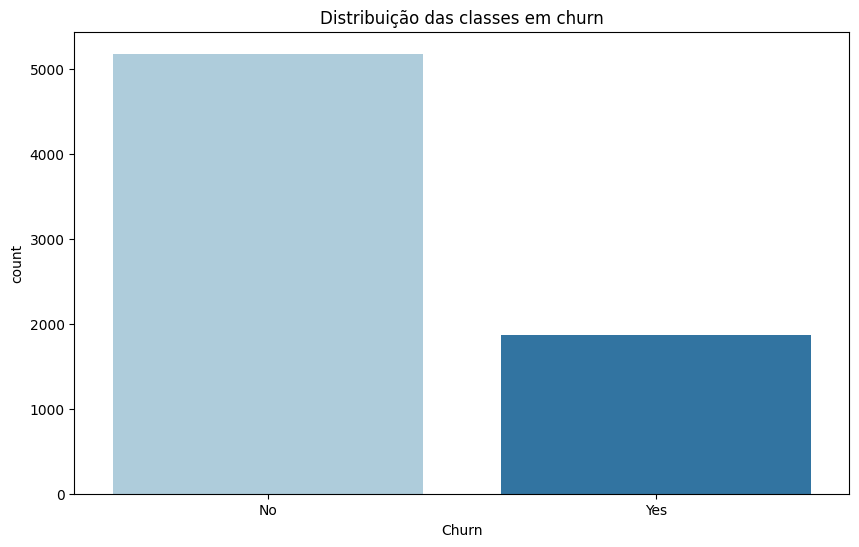

In [23]:
# Gráfico da Distribuição das classes em churn
plt.figure(figsize=(10, 6))
sns.countplot(x='Churn', data=dataset, palette='Paired', legend=False, hue='Churn')
plt.title('Distribuição das classes em churn')
plt.show()

A classificação desequilibrada é um problema comum no aprendizado de máquina, especialmente no domínio da classificação binária. Isso ocorre quando o conjunto de dados de treinamento tem uma distribuição desigual de classes, levando a um possível viés no modelo treinado. É importante abordar o desequilíbrio de classes para melhorar o desempenho do nosso modelo e garantir sua precisão.

## Modificando os Pesos na Função de Perda

A atribuição de pesos diferentes aos exemplos na função de perda pode ajudar a compensar o desequilíbrio. Isso significa dar maior importância aos exemplos da classe minoritária durante o treinamento do modelo.

**`(y_train == 1).sum()`**: Este trecho conta quantas vezes a classe `1` aparece no conjunto de dados de treino. Isso é feito comparando cada elemento de `y_train` com `1` (verdadeiro onde a condição é atendida) e somando esses valores verdadeiros.

**`(y_train == 0).sum()`**: Similarmente, este trecho conta quantas vezes a classe `0` aparece em `y_train`.

**Divisão**: A divisão do número de exemplos da classe minoritária (1) pelo número de exemplos da classe majoritária(0) calcula um fator de peso. Esse peso será usado para equilibrar as classes, aumentando a importância das instâncias da classe minoritária durante o treinamento do modelo.

In [24]:
# Calculando os pesos para cada classe
weights = (y_train == 1).sum() / (1.0 * (y_train == 0).sum())

xg_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.01, 
    max_depth=5,         # Quantidade de camadas, quanto mais camadas, mais complexo
    subsample=0.7,       # Quantidade de amostras por árvore, quanto menos amostras, mais rápido
    colsample_bytree=0.7,# Quantidade de colunas por árvore, quanto menos colunas, mais rápido
    reg_alpha=0.01,      # Regularização L1
    reg_lambda=1.0,      # Regularização L2
    objective='binary:logistic',
    random_state=42,
    scale_pos_weight=weights
)

# Treinamento do modelo
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [25]:
predictions = xg_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.7815602836879433
              precision    recall  f1-score   support

         0.0       0.77      0.99      0.87       511
         1.0       0.88      0.24      0.37       194

    accuracy                           0.78       705
   macro avg       0.83      0.61      0.62       705
weighted avg       0.80      0.78      0.73       705



In [26]:
nn_predictions = nn_model.predict(X_test)[:, 0]  # Retorna a probabilidade da classe positiva
xgb_predictions = xg_model.predict_proba(X_test)[:, 1]  # Retorna a probabilidade da classe positiva

# Média das previsões
final_predictions = (nn_predictions + xgb_predictions) / 2

# Acurácia
final_class_predictions = (final_predictions > 0.5).astype(int)
print("Ensemble Accuracy:", accuracy_score(y_test, final_class_predictions))

23/23 [==============================] - 0s 2ms/step
Ensemble Accuracy: 0.7872340425531915


In [27]:
# Classification report
print(classification_report(y_test, final_class_predictions))

              precision    recall  f1-score   support

         0.0       0.78      0.98      0.87       511
         1.0       0.82      0.29      0.43       194

    accuracy                           0.79       705
   macro avg       0.80      0.63      0.65       705
weighted avg       0.79      0.79      0.75       705



### Análise de Classe
- **Classe 0 (Majoritária)**
  - **Precisão**: 0.80. Isso indica que 80% das previsões para classe 0 estão corretas.
  - **Recall**: 0.97. Significa que 97% das instâncias reais de classe 0 foram identificadas corretamente pelo modelo.
  - **F1-Score**: 0.87. O F1-score é uma média harmônica de precisão e recall, e um valor de 0.87 sugere um bom equilíbrio entre precisão e recall para esta classe.
  - **Suporte**: 511. Número total de casos reais da classe 0 no conjunto de teste.

- **Classe 1 (Minoritária)**
  - **Precisão**: 0.81. Isto sugere que 81% das previsões de classe 1 pelo modelo estão corretas.
  - **Recall**: 0.35. Apenas 37% das instâncias reais de classe 1 foram identificadas corretamente, o que é bastante baixo.
  - **F1-Score**: 0.49. Este valor mais baixo indica uma baixa eficácia do modelo em equilibrar a precisão e o recall para a classe minoritária.
  - **Suporte**: 194. Número total de casos reais da classe 1 no conjunto de teste.

### Análise Agregada
- **Acurácia**: 0.80. Isso mostra que o modelo acertou 80% das vezes para todas as previsões feitas.
- **Média Macro (avg)**:
  - **Precisão**: 0.80. Média simples das precisões para ambas as classes.
  - **Recall**: 0.66. Média simples dos recalls, afetada negativamente pelo baixo recall da classe 1.
  - **F1-Score**: 0.68. Indica a média do F1-score, que também é puxada para baixo pela performance na classe 1.
- **Média Ponderada (weighted avg)**:
  - **Precisão**: 0.80. Considera o número de instâncias em cada classe, dando mais peso à classe 0.
  - **Recall**: 0.80. Similar à precisão, ponderada pelo suporte.
  - **F1-Score**: 0.77. F1-score ponderado que favorece a classe com mais suporte.

Ponderar os pesos pode aumentar a precisão da classe minoritária, porém o recall e o f1-score podem ser afetados negativamente. Portanto, é importante encontrar um equilíbrio entre as métricas de avaliação para ambas as classes.

# Engenharia de Recursos

Um tema comum em aprendizado de máquina é a seleção de boas características para maximizar o desempenho do modelo.

Para conjuntos de dados estruturados, geralmente há dois passos para escolher um conjunto final de características:

1. **Engenharia de características**: criação de novas características a partir dos dados (por exemplo, a partir do preço unitário e do volume total, talvez criar uma característica de receita total, igual ao preço vezes o volume).

2. **Seleção de características**: de um conjunto de características $ p $, selecionar um subconjunto que mantenha (ou até melhore) o desempenho.

Para realizar esses passos, existem considerações técnicas e empresariais. Não cobriremos as últimas: elas geralmente são específicas da aplicação e, o mais importante, dependem fortemente dos dados disponíveis.

Portanto, nos concentraremos nos métodos técnicos para realizar a seleção de características: dado um conjunto de características $ x_1, \ldots, x_p $, podemos selecionar um subconjunto $ x_1',\ldots, x_m' $ (onde $ m $ representa "mínimo") que nos leve a um nível ótimo de desempenho do modelo?

Uma resposta comum (antiga) é que $ p > N $ significa muitas características. Isso sempre foi o caso em estatísticas tradicionais, para métodos como regressão linear ou logística, para os quais $ p > N $ literalmente significa que o algoritmo quebra, já que a matriz $ X^T X $ não é mais invertível.

Essa não é mais uma resposta satisfatória. De fato, é comum, por exemplo, em genômica, ter conjuntos de dados onde $ p \gg N $: dados de expressão genética geralmente consideram $ p $ na ordem de 10.000 ou até 100.000 mil, enquanto $ N $ pode ser de algumas centenas (um para cada paciente no estudo, por exemplo).

O mesmo pode ser visto em problemas como processamento de imagens, onde cada pixel contribui com $ O(1) $ características. À medida que os tamanhos das imagens aumentam, a contagem total de características escala quadraticamente.

Para crédito, é comum ter conjuntos de dados com $ p $ entre 100-10.000 características relativas à informação financeira, comportamental e demográfica de um indivíduo. $ N $ aqui geralmente será na ordem de 100.000 - 100 milhões, ou seja, uma porcentagem da população (considerando o caso brasileiro com população total de cerca de 200 milhões).

**Há sempre características inúteis.** No caso da genômica, nem todos os genes estão ativos em um determinado momento - apenas uma fração deles contribui para o fenômeno de interesse. Em uma imagem de 800x600 de um gato, apenas uma pequena parte dos pixels descreverá realmente o gato, com o restante sendo objetos que não são de interesse. Da mesma forma, por mais rica que seja a informação das características de um indivíduo, apenas algumas contribuirão para seu comportamento de crédito.

**Nosso objetivo é então encontrar maneiras sistemáticas de filtrar características inúteis.**

É senso comum que, se você tem poucas características, seu modelo pode simplesmente não ter informações suficientes para ter um bom desempenho.

Menos óbvio é que ter muitas características também pode ser problemático. Elas podem causar perda de desempenho devido a algumas razões relacionadas:

- **Sobreajuste**: quanto mais características, mais difícil será para os pontos terem vizinhos próximos (a chamada maldição da dimensionalidade); você precisará de exponencialmente mais dados para cobrir o espaço de características de maneira significativa. Seu algoritmo é propenso a apenas sobreajustar;

- **Ruído**: variáveis inúteis introduzem ruído que pode afetar o treinamento;

- **Considerações de tempo/espaço**: quanto mais dimensões, mais memória seu computador precisa, e mais tempo levará para treinamento, otimização de hiperparâmetros, etc.

Um dos métodos para seleção de características é o algoritmo Boruta, introduzido em 2010 por Kursa e Rudnicki. Ele se provou consistentemente como uma ferramenta poderosa para seleção direta de boas características em casos com milhares de características.

De maneira simples, o Boruta funciona da seguinte forma: para cada característica, digamos `x1`, o Boruta cria uma cópia `x1_copy` (chamada de *sombra* pelos autores) e então mistura aleatoriamente os valores entre todos os pontos, criando ruído.

Ele então ajusta um modelo (geralmente uma floresta aleatória) implementando um método de importância de características e analisa como a importância da característica original se compara às cópias ruidosas. Se elas forem significativamente diferentes, então `x1` é considerada valiosa e mantida; se não, significa que `x1` é basicamente ruído, e é removida.

No caso de desequilíbrio de classes, **não use o upsampling**; em vez disso, faça uma validação cruzada com um **undersampling** da classe majoritária durante a seleção de características. Para o Boruta, use um **classificador base RandomForest com pesos**: `class_weight='balanced_subsample'`, e para o modelo final (treinado com todo o conjunto de treinamento usando as características selecionadas), veja se usar `class_weight` dá um resultado melhor do que não usá-lo.

O parâmetro `perc` é um parâmetro extremamente importante introduzido na versão Python. Ele basicamente define quão "flexível" queremos ser com nossas características: `perc=100` é o mais rigoroso, e quanto mais próximo de 0, mais flexíveis somos ao permitir que características menos importantes sejam selecionadas.

Usaremos o Boruta com florestas aleatórias.

Como observado pelo próprio autor (em *Boruta para quem tem pressa*, Miron B. Kursa, 21 de maio de 2020), é importante que tenhamos um número suficiente de árvores:
> "Para conjuntos de dados com muitas características, a configuração padrão da fonte de importância provavelmente é insuficiente; no caso particular do Random Forest, o número de árvores muitas vezes não é grande o suficiente para permitir que os escores de importância se estabilizem, o que, por sua vez, muitas vezes leva a falsos negativos e resultados instáveis."

Isso pode ser resolvido permitindo que o próprio Boruta identifique um número ótimo de árvores.

In [28]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from boruta.boruta_py import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [29]:
def select_feature_boruta(X, y, 
                         perc=100,
                         alpha=0.05,
                         max_iter=100,
                         max_depth=7,
                         n_estimators='auto',
                         n_jobs=1):

    X_is_df = isinstance(X, pd.DataFrame)
    y_is_df = isinstance(y, pd.Series)
        
    selector = BorutaPy(
            estimator=RandomForestClassifier(n_estimators=100, max_depth=max_depth, n_jobs=n_jobs),
            n_estimators=n_estimators,
            perc=perc,      
            alpha=alpha,    
            max_iter=max_iter,
            random_state=1,
            verbose=0,
        )

    # boruta needs a numpy array, not a dataframe
    X_train = X.values if X_is_df else X
    y_train = y.values if y_is_df else y

    selector.fit(X_train, y_train) 
        
    if X_is_df:
        columns = X.columns
        return sorted(np.array(columns)[selector.support_.tolist()])
    else:
        return sorted(selector.support_.tolist())

In [30]:
selected_features = select_feature_boruta(X_train, y_train, n_jobs=10)
selected_features

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations